<a href="https://colab.research.google.com/github/PhamQuocHuy1101/acea-water-prediction/blob/master/DoAnCuoiKi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [27]:
import os
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('./drive/MyDrive/cacMoHinhPhanTichDuLieu')

In [ ]:
# df = pd.read_csv('./Aquifer_Petrignano.csv') # Good 8
# df = pd.read_csv('./data/Lake_Bilancino.csv') # Good 9
# df = pd.read_csv('./River_Arno.csv') # Good 17
# df = pd.read_csv('./Water_Spring_Amiata.csv') # Good 14
# df.head()

# Preprocessing

In [28]:
df = pd.read_csv('./checkpoint/clean_data.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

In [29]:
test_size = 0.1
break_point = int(len(df) * (1 - test_size))
train_df, test_df = df[:break_point], df[break_point:]

break_point = int(len(train_df) * (1 - test_size))
train_df, val_df = train_df[:break_point], train_df[break_point:]

len(train_df), len(test_df)

(3401, 420)

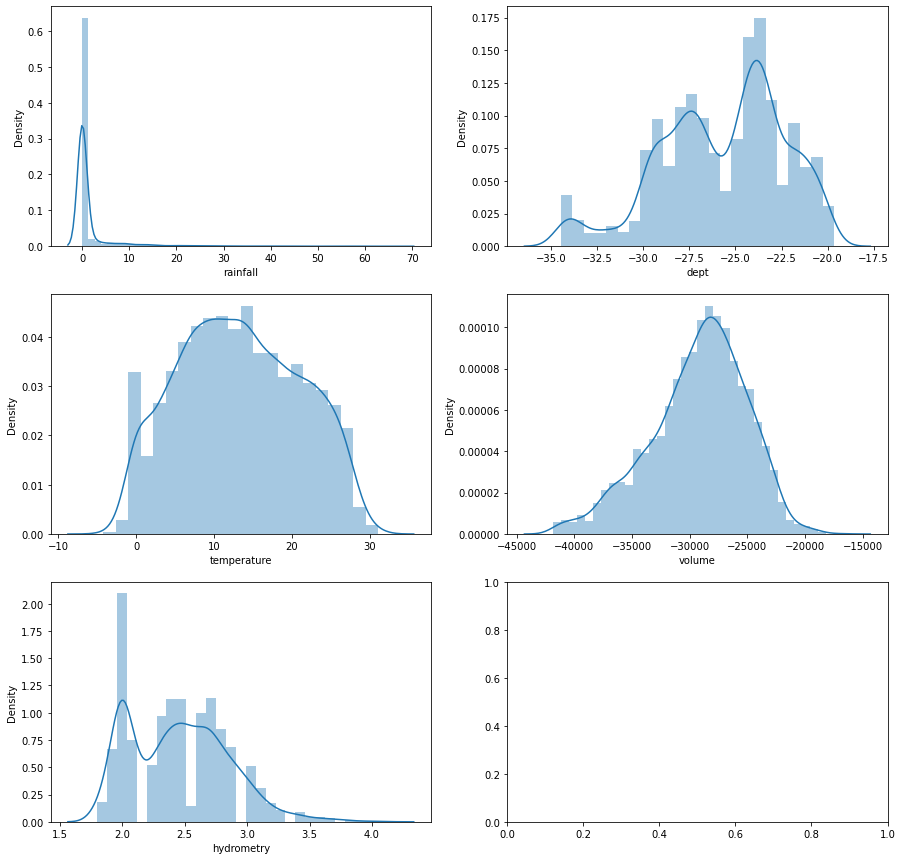

In [31]:
_, axs = plt.subplots(nrows = 3, ncols=2, figsize =(15, 15))
flat_axs = axs.flatten()
for fax, col in zip(flat_axs, train_df.columns[1:]):
    sns.distplot(train_df[col], kde=True, ax=fax)

We can use MinMaxScaler, StandarScaler. But the distribution of many features not in bell shape, so we decide to to MinMaxScaler

In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [37]:
train_des = train_df.describe()
train_des

,rainfall,dept,temperature,volume,hydrometry
count,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000
mean,1.475066,-25.701915,13.305587,-29215.017950,2.455984
std,5.105912,3.342920,7.743870,4134.033948,0.395584
min,0.000000,-34.470000,-4.200000,-41890.176000,1.800000
25%,0.000000,-28.000000,7.200000,-31650.048000,2.100000
50%,0.000000,-25.040000,13.000000,-28740.096000,2.431788
75%,0.000000,-23.330000,19.400000,-26329.536000,2.700000
max,67.300000,-19.660000,31.100000,-16790.112000,4.100000


In [38]:
feature_col = ['rainfall', 'temperature', 'volume', 'hydrometry']
target_col = ['dept']

scaler_X = MinMaxScaler()
scaler_X.fit(train_df[feature_col])
scaler_Y = MinMaxScaler()
scaler_Y.fit(train_df[target_col])
import pickle

pickle.dump(scaler_X, open('./checkpoint/feature_scaler.pkl', 'wb'))
pickle.dump(scaler_Y, open('./checkpoint/target_scaler.pkl', 'wb'))

In [39]:
def get_preprocessing():
    scaler_X = pickle.load(open('./checkpoint/feature_scaler.pkl', 'rb'))
    scaler_Y = pickle.load(open('./checkpoint/target_scaler.pkl', 'rb'))
    def preprocessing_pipeline(df):
        X = scaler_X.transform(df[feature_col])
        Y = scaler_Y.transform(df[target_col])
        return X, Y
    return preprocessing_pipeline

# Training LSTM model

## Prepare data for training

In [41]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [43]:
def make_time_series_data(X, Y, duration):
    X_new, Y_new = [], []
    for i in range(len(Y)):
        break_point = i + duration
        if break_point < len(Y):
            x, y = X[i:break_point], Y[break_point]
            X_new.append(x)
            Y_new.append(y)
        else:
            break
    return np.stack(X_new, axis = 0), np.stack(Y_new, axis = 0)

In [61]:
def plot_prediction(y, y_hat):
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(np.arange(len(y)), y.flatten(), ax=ax, label='original')
    sns.lineplot(np.arange(len(y)), y_hat.flatten(), ax=ax, label='prediction', color='orange')

In [44]:
preprocessing = get_preprocessing()

## Univariable model

In [45]:
duration = 30 # Use the value of 30 day before to forecast the next value
train_X, train_Y = preprocessing_pipeline(train_df)
shift_X, shift_Y = make_time_series_data(train_Y, train_Y, duration)

val_X, val_Y = preprocessing_pipeline(val_df)
shift_X_val, shift_Y_val = make_time_series_data(val_Y, val_Y, duration)

shift_X.shape, shift_X_val.shape

((3371, 30, 1), (348, 30, 1))

In [47]:
def build_model_univariable():
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(duration, 1)))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(1))
    return model
    
model = build_model_univariable()
model.compile(optimizer='adam', loss='mean_squared_error')
# fit model
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/uni_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.fit(shift_X, shift_Y, epochs=30, batch_size=8, validation_data=(shift_X_val, shift_Y_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
422/422 [==============================] - 47s 46ms/step - loss: 0.0083 - val_loss: 1.9493e-04
Epoch 2/30
422/422 [==============================] - 20s 48ms/step - loss: 3.4231e-04 - val_loss: 3.9335e-04
Epoch 3/30
422/422 [==============================] - 18s 43ms/step - loss: 3.1764e-04 - val_loss: 2.1737e-04
Epoch 4/30
422/422 [==============================] - 18s 42ms/step - loss: 2.7686e-04 - val_loss: 1.4704e-04
Epoch 5/30
422/422 [==============================] - 19s 45ms/step - loss: 2.7911e-04 - val_loss: 1.6952e-04
Epoch 6/30
422/422 [==============================] - 18s 43ms/step - loss: 2.3784e-04 - val_loss: 1.1046e-04
Epoch 7/30
422/422 [==============================] - 18s 43ms/step - loss: 2.1743e-04 - val_loss: 1.0985e-04
Epoch 8/30
422/422 [==============================] - 18s 42ms/step - loss: 2.1221e-04 - val_loss: 1.7344e-04
Epoch 9/30
422/422 [==============================] - 20s 47ms/step - loss: 2.0157e-04 - val_loss: 1.7040e-04
Epoch 10/30
42

The mean absolute error:  0.09957830771421783


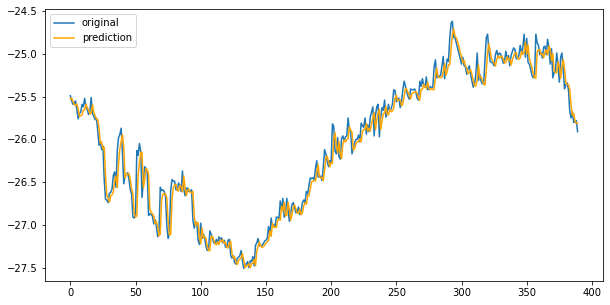

In [52]:
model = build_model_univariable()
model.load_weights('./checkpoint/uni_model.h5')
X_test, Y_test = preprocessing_pipeline(test_df)
shift_X, shift_Y = make_time_series_data(Y_test, Y_test, duration)
y_hat = model.predict(shift_X)

tY, tY_hat = scaler_Y.inverse_transform(shift_Y), scaler_Y.inverse_transform(y_hat.reshape(-1, 1))
mean_error = np.abs(tY.flatten() - tY_hat.flatten()).mean()
print('The mean absolute error: ', mean_error)
plot_prediction(tY, tY_hat)

# Multivariable Model

In [58]:
duration = 30 # Use the value of 30 day before to forecast the next value
train_X, train_Y = preprocessing_pipeline(train_df)
shift_X, shift_Y = make_time_series_data(train_X, train_Y, duration) # multivariables

val_X, val_Y = preprocessing_pipeline(val_df)
shift_X_val, shift_Y_val = make_time_series_data(val_X, val_Y, duration)

shift_X.shape, shift_X_val.shape

((3371, 30, 4), (348, 30, 4))

In [59]:
def build_model_multivariable():
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(duration, 4)))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(1))
    return model
    
model = build_model_multivariable()
model.compile(optimizer='adam', loss='mean_squared_error')
# fit model
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/multi_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.fit(shift_X, shift_Y, epochs=30, batch_size=8, validation_data=(shift_X_val, shift_Y_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
422/422 [==============================] - 23s 44ms/step - loss: 0.0454 - val_loss: 0.0048
Epoch 2/30
422/422 [==============================] - 17s 41ms/step - loss: 0.0293 - val_loss: 0.0056
Epoch 3/30
422/422 [==============================] - 16s 39ms/step - loss: 0.0278 - val_loss: 0.0027
Epoch 4/30
422/422 [==============================] - 16s 38ms/step - loss: 0.0276 - val_loss: 0.0064
Epoch 5/30
422/422 [==============================] - 17s 40ms/step - loss: 0.0252 - val_loss: 0.0024
Epoch 6/30
422/422 [==============================] - 17s 40ms/step - loss: 0.0254 - val_loss: 0.0120
Epoch 7/30
422/422 [==============================] - 17s 41ms/step - loss: 0.0247 - val_loss: 0.0027
Epoch 8/30
422/422 [==============================] - 17s 41ms/step - loss: 0.0223 - val_loss: 0.0103
Epoch 9/30
422/422 [==============================] - 17s 40ms/step - loss: 0.0210 - val_loss: 0.0065
Epoch 10/30
422/422 [==============================] - 19s 46ms/step - loss: 0.019

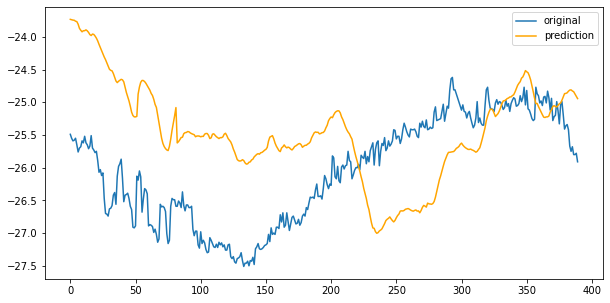

In [60]:
model = build_model_multivariable()
model.load_weights('./checkpoint/multi_model.h5')
X_test, Y_test = preprocessing_pipeline(test_df)
shift_X, shift_Y = make_time_series_data(X_test, Y_test, duration)
y_hat = model.predict(shift_X)

tY, tY_hat = scaler_Y.inverse_transform(shift_Y), scaler_Y.inverse_transform(y_hat.reshape(-1, 1))
d = np.abs(tY.flatten() - tY_hat.flatten()).mean()
plot_prediction(tY, tY_hat)